In [1]:
import tensorflow as tf

if hasattr(tf, 'keras'):
    from tensorflow.keras.applications import VGG19
else:
    from keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 

In [5]:
base_bone_dir = r'C:\Users\ASUS\Downloads\Try_hats_dawg\B3\boneage_mlmed'
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(
    lambda x: os.path.join(
        base_bone_dir,
        'boneage-training-dataset',  
        'boneage-training-dataset',
        f'{x}.png'  
    )
)

age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')

# Process gender column
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')

# Calculate bone age statistics (original values)
boneage_mean = age_df['boneage'].mean()
boneage_div = 2 * age_df['boneage'].std()

# Calculate z-score
age_df['boneage_zscore'] = age_df['boneage'].map(
    lambda x: (x - boneage_mean) / boneage_div
)

# Clean data
age_df.dropna(inplace=True)

# Display sample
age_df.sample(3)

12611 images found of 12611 total


id  boneage   male                                               path  \
3989  5993      126   True  C:\Users\ASUS\Downloads\Try_hats_dawg\B3\bonea...   
4906  7012       88  False  C:\Users\ASUS\Downloads\Try_hats_dawg\B3\bonea...   
6338  8602      126  False  C:\Users\ASUS\Downloads\Try_hats_dawg\B3\bonea...   

      exists  gender  boneage_zscore  
3989    True    male       -0.016036  
4906    True  female       -0.477402  
6338    True  female       -0.016036

## EDA

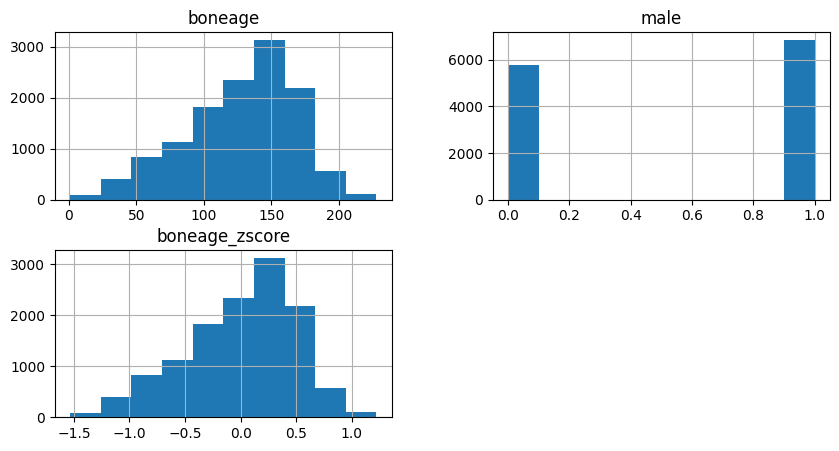

In [6]:
age_df[['boneage', 'male', 'boneage_zscore']].astype({'male': int}).hist(figsize=(10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

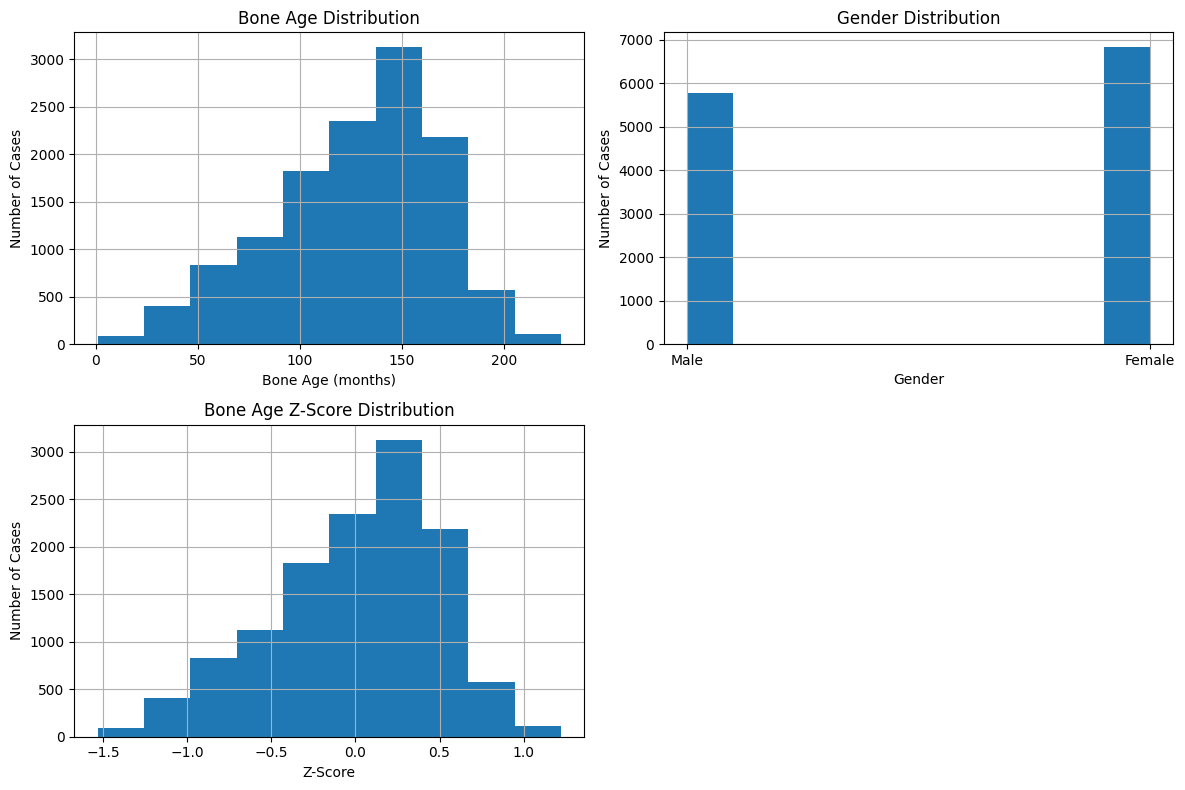

In [9]:
import matplotlib.pyplot as plt

# Create histograms - will generate 3 plots in a 2x2 grid (since 3 doesn't divide evenly)
axes = age_df[['boneage', 'male', 'boneage_zscore']].astype({'male': int}).hist(figsize=(12, 8))

# Customize titles and labels
# Bone Age (will be at position [0,0] in the grid)
axes[0,0].set_title('Bone Age Distribution')
axes[0,0].set_xlabel('Bone Age (months)')
axes[0,0].set_ylabel('Number of Cases')

# Gender (will be at position [0,1])
axes[0,1].set_title('Gender Distribution')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Number of Cases')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['Male', 'Female'])

# Z-Score (will be at position [1,0] - second row)
axes[1,0].set_title('Bone Age Z-Score Distribution')
axes[1,0].set_xlabel('Z-Score')
axes[1,0].set_ylabel('Number of Cases')

# Remove the empty 4th subplot (if exists)
if len(axes.flatten()) > 3:
    axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
gender_counts = age_df['male'].value_counts()
print(f"Female count: {gender_counts[0]}")
print(f"Male count: {gender_counts[1]}")

Female count: 6833
Male count: 5778


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3140\531020384.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Female count: {gender_counts[0]}")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3140\531020384.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Male count: {gender_counts[1]}")


## Split Data into Training and Validation

In [5]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


## Balance the distribution in the training set

New Data Size: 10000 Old Size: 9458


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10188\876977220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10188\876977220.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)


array([[<Axes: title={'center': 'boneage'}>]], dtype=object)

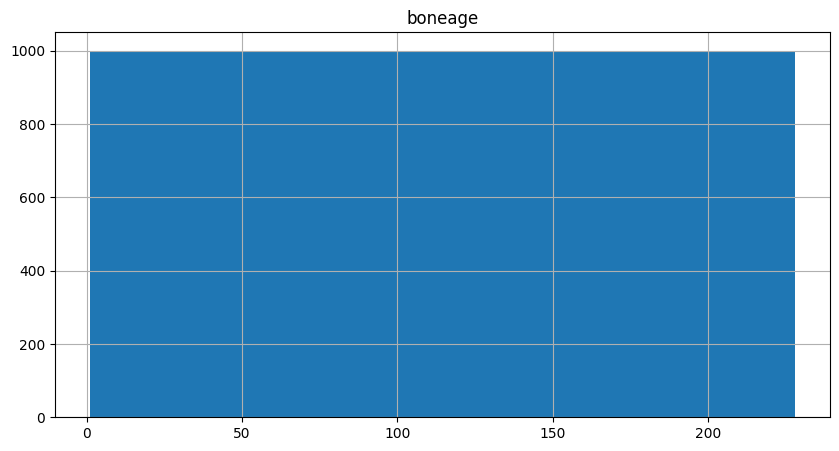

In [6]:
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'male']].hist(figsize = (10, 5))

- Groups the data by boneage_category (10 bins) and male (2 genders).

    - Samples 500 rows per group (with replace=True, meaning repetitions are allowed).

- Result:

    - 10 bone age categories × 2 genders × 500 samples = 10,000 total rows.

Some groups had <500 samples, so replace=True duplicates existing rows to reach 500.

Others had >500 samples, but only 500 are kept (no duplicates).


## Data augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than upsampling normal vgg19 expect

# --- Generator with AUGMENTATIONS (for TRAINING only) ---
train_idg = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=False,
    height_shift_range=0.15,
    width_shift_range=0.15,
    rotation_range=5,
    shear_range=0.01,
    zoom_range=0.25,
    fill_mode='nearest'
)

# --- Generator WITHOUT AUGMENTATIONS (for VALIDATION/TEST) ---
test_idg = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Only preprocessing, no augmentations
)

In [8]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(
        dataframe=in_df,
        directory=None,  
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',  # For regression tasks
        **dflow_args
    )
    
    # Replace with dataframe values
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''  # since we have full paths
    
    print(f'Successfully created generator for {in_df.shape[0]} images')
    return df_gen

In [9]:
# --- TRAINING (with augmentation) ---
train_gen = flow_from_dataframe(
    train_idg, 
    train_df,
    path_col='path',
    y_col='boneage_zscore',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32
)

# --- VALIDATION (no augmentation) ---
valid_gen = flow_from_dataframe(
    test_idg,  # Uses test_idg (no augmentations)
    valid_df,
    path_col='path',
    y_col='boneage_zscore',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=256
)

# --- TEST (no augmentation, single large batch) ---
test_X, test_Y = next(flow_from_dataframe(
    test_idg,
    valid_df,
    path_col='path',
    y_col='boneage_zscore',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=1024
))

Found 10000 validated image filenames.
Successfully created generator for 10000 images
Found 3153 validated image filenames.
Successfully created generator for 3153 images
Found 3153 validated image filenames.
Successfully created generator for 3153 images


In [10]:
print(len(valid_df))

3153


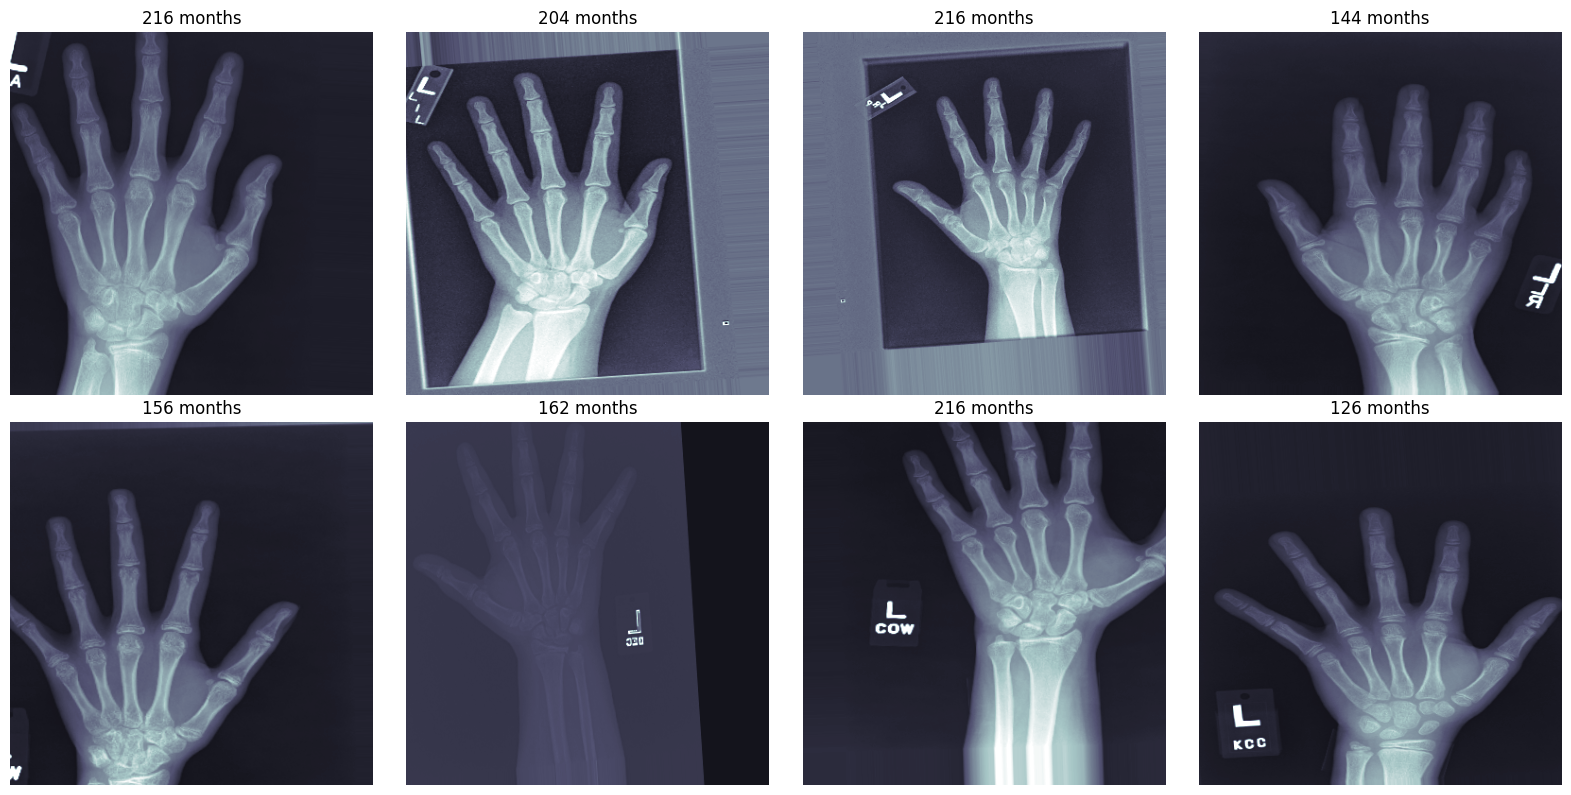

In [21]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')
plt.tight_layout()
plt.show()

## VGG19

In [34]:
from keras.applications.vgg19 import VGG19  
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model

# Input layer
in_lay = Input(t_x.shape[1:])

# load and freeze VGG19 layers
base_pretrained_model = VGG19(input_shape=t_x.shape[1:], include_top=False, weights='imagenet')
base_pretrained_model.trainable = False  # Freeze VGG19 layers
pt_depth = base_pretrained_model.output_shape[-1]

# Pass input through VGG19
pt_features = base_pretrained_model(in_lay)

# Batch normalization
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off
# Attention mechanism
attn_layer = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
attn_layer = Conv2D(16, kernel_size=(1,1), padding='same', activation='relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                              kernel_size=(1,1), 
                              padding='valid', 
                              activation='sigmoid')(attn_layer)

# expanding it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size=(1,1), padding='same',
             activation='linear', use_bias=False, weights=[up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

# Apply attention
mask_features = multiply([attn_layer, bn_features])

# Global Average Pooling
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
# Rescale features by attention
gap = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([gap_features, gap_mask])

# Final dense layers
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation='elu')(gap_dr))
out_layer = Dense(1, activation='linear')(dr_steps)  # Linear activation for regression

bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 12, 12, 512)  20024384    ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 12, 512)  2048       ['vgg19[0][0]']                  
 alization)                                                                                       
                                                                                              

In [41]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights.best.hdf5".format('bone_age_vgg19')  

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6, 
    patience=15,  
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=8,   
    min_lr=0.0001  
)

early = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,  
    restore_best_weights=True
)


from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat]  

In [42]:
# Training implementation with validation data
history = bone_age_model.fit_generator(
    generator=train_gen,  
    validation_data=(test_X, test_Y),  
    steps_per_epoch=len(train_gen),  
    epochs=5,  
    callbacks=callbacks_list, 
    verbose=1
)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10912\1083837886.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = bone_age_model.fit_generator(


Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.2463 - mae_months: 31.9040     
Epoch 1: val_loss improved from inf to 0.10582, saving model to bone_age_vgg19_weights.best.hdf5
313/313 [==============================] - 2857s 9s/step - loss: 0.2463 - mae_months: 31.9040 - val_loss: 0.1058 - val_mae_months: 21.1152 - lr: 0.0010
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.1494 - mae_months: 25.2018   
Epoch 2: val_loss improved from 0.10582 to 0.09465, saving model to bone_age_vgg19_weights.best.hdf5
313/313 [==============================] - 2868s 9s/step - loss: 0.1494 - mae_months: 25.2018 - val_loss: 0.0947 - val_mae_months: 20.1976 - lr: 0.0010
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1210 - mae_months: 22.6129   
Epoch 3: val_loss improved from 0.09465 to 0.07331, saving model to bone_age_vgg19_weights.best.hdf5
313/313 [==============================] - 2894s 9s/step - loss: 0.1210 - mae_months: 22.612

1/1 [==============================] - 0s 253ms/step
Found attention layer: locally_connected2d
1/1 [==============================] - 0s 301ms/step


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10912\2530343378.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age / 12))


1/1 [==============================] - 0s 321ms/step


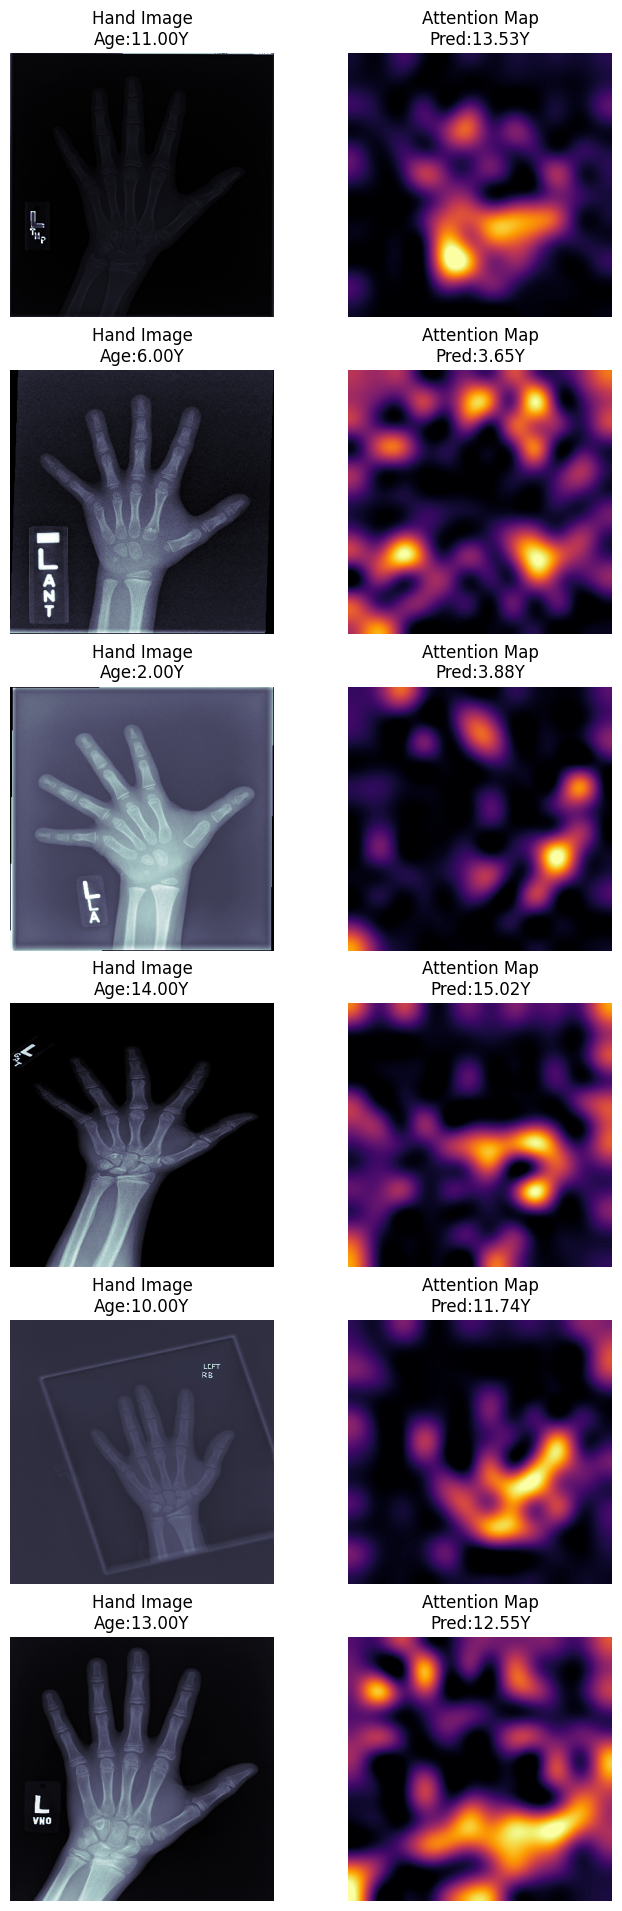

In [95]:
# Load the best version of the model
bone_age_model.load_weights(weight_path)

# Ensure the model is built
_ = bone_age_model.predict(np.expand_dims(test_X[0], axis=0))

# Find attention layer
attn_layer = None
for layer in bone_age_model.layers:
    try:
        c_shape = layer.output_shape
        if len(c_shape) == 4 and c_shape[-1] == 1:
            print("Found attention layer:", layer.name)
            attn_layer = layer
            break
    except:
        continue

if attn_layer is None:
    raise ValueError("No attention layer found in the model")

# Create attention model
attention_model = tf.keras.Model(inputs=bone_age_model.input,
                                outputs=attn_layer.output)

rand_idx = np.random.choice(range(len(test_X)), size=6)

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize=(8, 4 * len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx + 1)]
    attn_img = attention_model.predict(cur_img)

    # Normalize attention map
    attn_img = (attn_img - np.min(attn_img)) / (np.max(attn_img) - np.min(attn_img))

    # 1. Adjust vmin and vmax to observed range
    vmin = np.min(attn_img)
    vmax = np.max(attn_img)

    img_ax.imshow(cur_img[0, :, :, 0], cmap='bone')

    # 2. Try a more sensitive colormap
    attn_ax.imshow(attn_img[0, :, :, 0], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='lanczos')

    real_age = boneage_div * test_Y[c_idx] + boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age / 12))

    pred_age = boneage_div * bone_age_model.predict(cur_img) + boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age / 12))

fig.savefig('attention_map.png', dpi=300)

Attention map range is very small, fluctuate around 0.00000002 to 0.4

In [96]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

32/32 [==============================] - 271s 8s/step


In [15]:
print(len(test_X))

1024


test_df has 1024 images
batchsize = 32 -> process 1024 images in chunks of 32

Text(0, 0.5, 'Predicted Age (Months)')

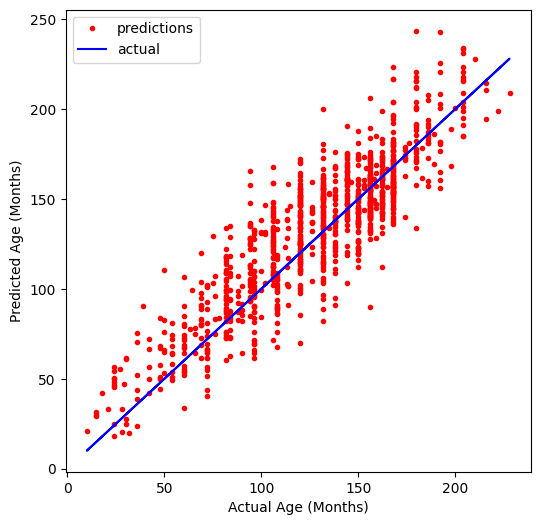

In [97]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10912\1087477992.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0,


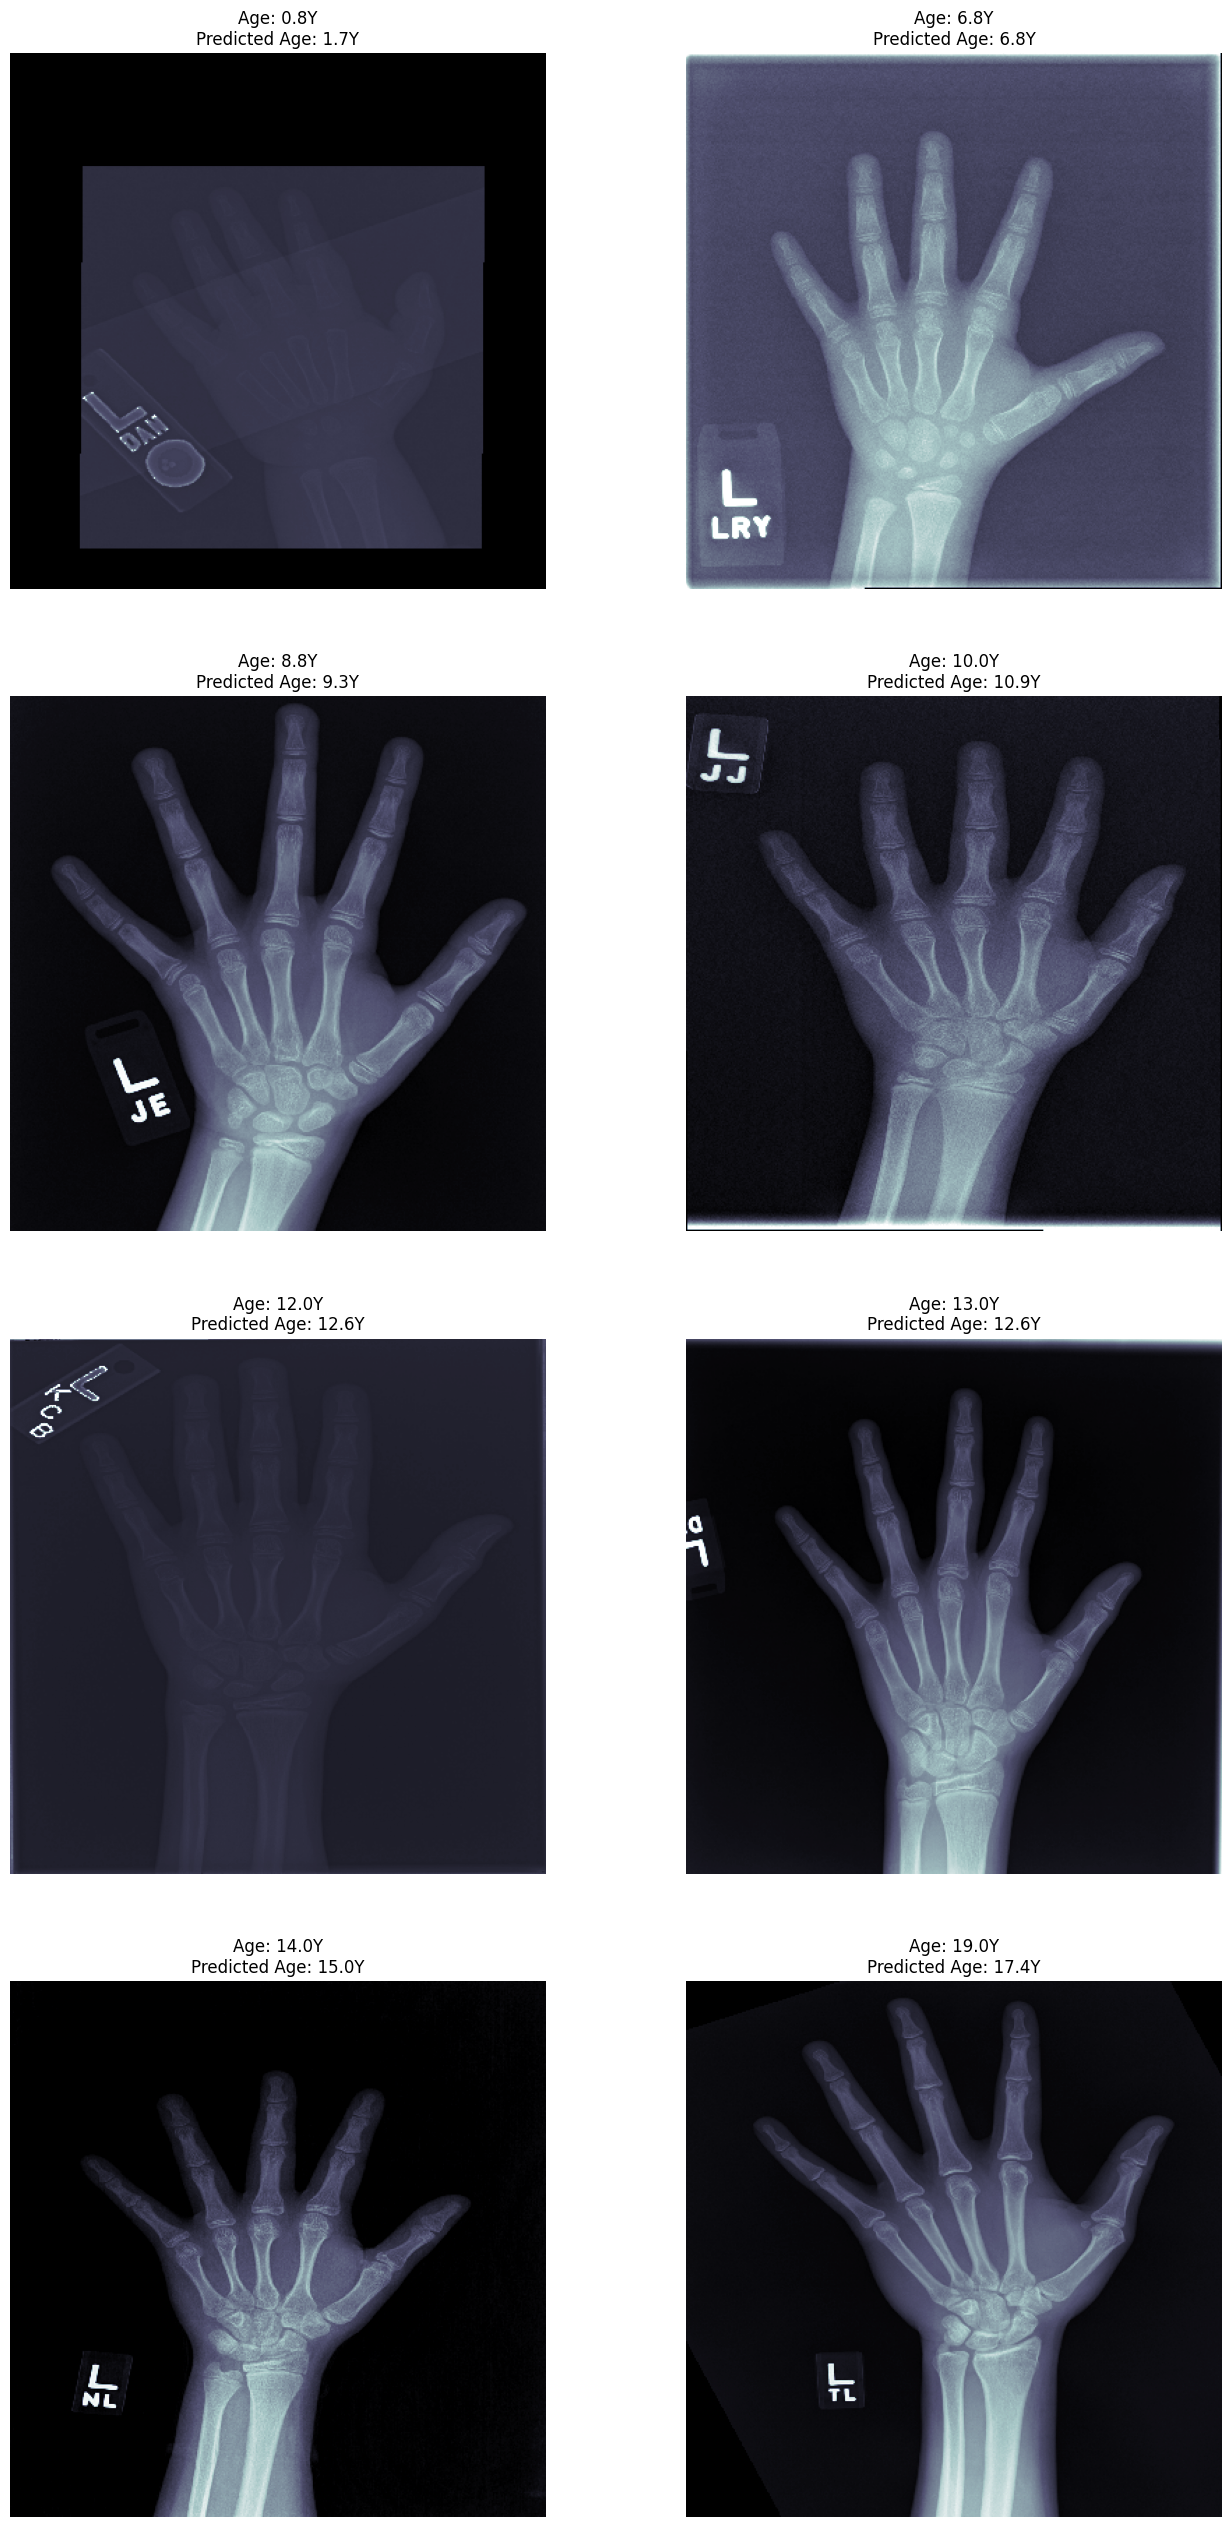

In [98]:
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predicted_bone_age_normalized = bone_age_model.predict(test_X)
predicted_bone_age = predicted_bone_age_normalized.flatten() * boneage_div + boneage_mean
true_bone_age = test_Y * boneage_div + boneage_mean

mae = mean_absolute_error(true_bone_age, predicted_bone_age)
mad = np.median(np.abs(true_bone_age - predicted_bone_age))
rmse = np.sqrt(mean_squared_error(true_bone_age, predicted_bone_age))
print(f"MAE: {mae:.4f} months")
print(f"MAD: {mad:.4f} months")
print(f"RMSE: {rmse:.4f} months")

32/32 [==============================] - 250s 8s/step
MAE: 16.2751 months
MAD: 13.5901 months
RMSE: 20.6213 months
